In [6]:
'''
stage --1
入力特徴量の分析を行いましょう！
ここはimport feature_extract_vcモジュールを呼び出すだけでいいのですが、あえて関数を再定義してます。

'''
from __future__ import division
from __future__ import print_function

import multiprocessing as mp
import matplotlib.pyplot as plt
import os
import sys

import numpy as np
from numpy.matlib import repmat

from scipy.interpolate import interp1d
from scipy.io import wavfile
from scipy.signal import firwin
from scipy.signal import lfilter

sys.path.append('/cyclevae/src/utils')
from utils import find_files
from utils import read_txt
from utils import write_hdf5, read_hdf5

from multiprocessing import Array

import pysptk as ps
import pyworld as pw

'''
NumPy の配列を表示するときに、すべての要素を出力するように設定
'''
np.set_printoptions(threshold=np.inf)

FS = 22050
SHIFTMS = 5
MINF0 = 40
MAXF0 = 700
MCEP_DIM = 49
MCEP_ALPHA = 0.455
FFTL = 1024
IRLEN = 1024
LOWPASS_CUTOFF = 20
HIGHPASS_CUTOFF = 70
OVERWRITE = True

working_dir = "/cyclevae/egs/one-to-one"
os.chdir(working_dir)

def extfrm(data, npow, power_threshold=-20):
    T = data.shape[0]
    if T != len(npow):
        raise("Length of two vectors is different.")
    #-20dBよりも大きいnpowを、有声音区間とする。
    valid_index = np.where(npow > power_threshold)
    #有声区間のフレームのみを抽出
    extdata = data[valid_index]
    
    #無音部分を除外するので、当然小さくなっていてほしい。
    assert extdata.shape[0] <= T

    return extdata, valid_index
def convert_continuos_f0(f0):
    """CONVERT F0 TO CONTINUOUS F0

    Args:
        f0 (ndarray): original f0 sequence with the shape (T)

    Return:
        (ndarray): continuous f0 with the shape (T)
    """
    # get uv information as binary
    uv = np.float32(f0 != 0)

    # get start and end of f0
    '''
    f0[f0 != 0]は、マスク。
    f0 != 0は、0以外の要素を抽出するということなので、
    [0,0,0,1,23,0]→[1,23]となる。
    '''
    start_f0 = f0[f0 != 0][0]
    end_f0 = f0[f0 != 0][-1]

    # padding start and end of f0 sequence
    start_idx = np.where(f0 == start_f0)[0][0]
    end_idx = np.where(f0 == end_f0)[0][-1]
    #音源の、最初と最後の無音区間を、start_f0、end_f0に置き換える。
    f0[:start_idx] = start_f0
    f0[end_idx:] = end_f0

    # get non-zero frame index
    nz_frames = np.where(f0 != 0)[0]

    # perform linear interpolation
    f = interp1d(nz_frames, f0[nz_frames])
    cont_f0 = f(np.arange(0, f0.shape[0]))

    return uv, cont_f0

def spc2npow(spectrogram):
    npow = np.apply_along_axis(spvec2pow, 1, spectrogram)

    meanpow = np.mean(npow)
    npow = 10.0 * np.log10(npow/meanpow)

    return npow


def spvec2pow(specvec):
    fftl2 = len(specvec) - 1
    fftl = fftl2 * 2

    power = specvec[0] + specvec[fftl2]
    for k in range(1, fftl2):
        power += 2.0 * specvec[k]
    power /= fftl

    return power

def low_pass_filter(x, fs, cutoff=LOWPASS_CUTOFF, padding=True):
    
    nyquist = fs // 2
    norm_cutoff = cutoff / nyquist

    # low cut filter
    numtaps = 255
    fil = firwin(numtaps, norm_cutoff)
    x_pad = np.pad(x, (numtaps, numtaps), 'edge')
    lpf_x = lfilter(fil, 1, x_pad)
    lpf_x = lpf_x[numtaps + numtaps // 2: -numtaps // 2]

    return lpf_x

def low_cut_filter(x, fs, cutoff=HIGHPASS_CUTOFF):
    nyquist = fs // 2
    norm_cutoff = cutoff / nyquist
    # low cut filter
    fil = firwin(255, norm_cutoff, pass_zero=False)
    lcf_x = lfilter(fil, 1, x)
    
    return lcf_x

def read_wav(wav_file, cutoff=HIGHPASS_CUTOFF):
    fs, x = wavfile.read(wav_file)
    x = np.array(x, dtype=np.float64)
    if cutoff != 0:
        x = low_cut_filter(x, fs, cutoff)

    return fs, x
def analyze(wav, fs=FS, minf0=MINF0, maxf0=MAXF0, fperiod=SHIFTMS, fftl=FFTL, f0=None, time_axis=None):
    #f0_flr = pw.get_cheaptrick_f0_floor(fs, fftl)
    #logging.info(f0_flr)
    #fft_size = pw.get_cheaptrick_fft_size(fs, f0_flr)
    #logging.info(fft_size)
    #f0_flr = pw.get_cheaptrick_f0_floor(fs, fft_size)
    #logging.info(f0_flr)
    if f0 is None or time_axis is None:
        _f0, time_axis = pw.harvest(wav, fs, f0_floor=60.0, frame_period=fperiod)
        f0 = pw.stonemask(wav, _f0, time_axis, fs) 
    sp = pw.cheaptrick(wav, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(wav, f0, time_axis, fs, fft_size=fftl)

    return time_axis, f0, sp, ap

def analyze_range(wav, fs=FS, minf0=MINF0, maxf0=MAXF0, fperiod=SHIFTMS, fftl=FFTL, f0=None, time_axis=None):
    if f0 is None or time_axis is None:
        _f0, time_axis = pw.harvest(wav, fs, f0_floor=minf0, f0_ceil=maxf0, frame_period=fperiod)
        f0 = pw.stonemask(wav, _f0, time_axis, fs) 
    sp = pw.cheaptrick(wav, f0, time_axis, fs, fft_size=fftl)
    ap = pw.d4c(wav, f0, time_axis, fs, fft_size=fftl)

    return time_axis, f0, sp, ap

args.waveforms はファイルです。
file_list のサイズ: 45
1
wav/bone_src/10011.wav
wav/bone_src/10011.wav 音声のサンプル数は:134550 wav_lists内の音声サンプルの総計は:134550 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: WavFileWarning: Chunk (non-data) not understood, skipping it.


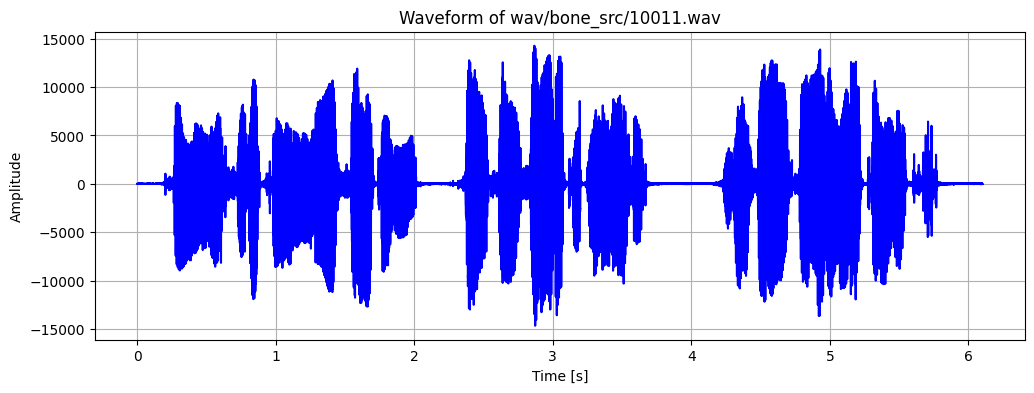

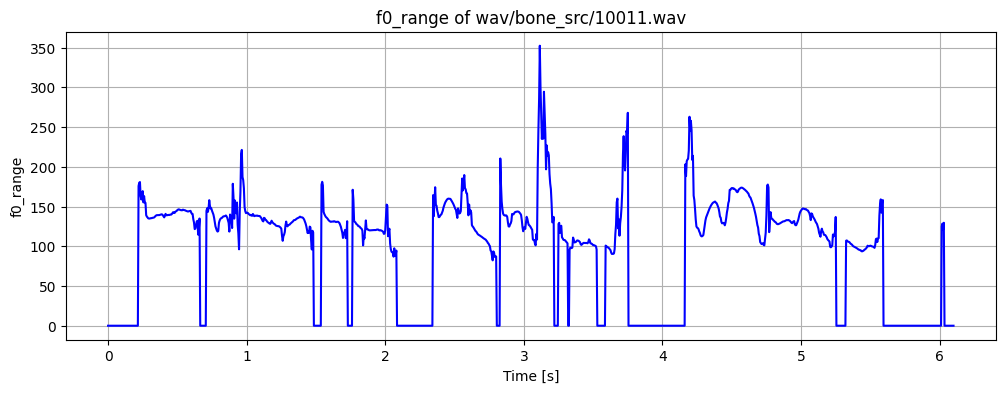

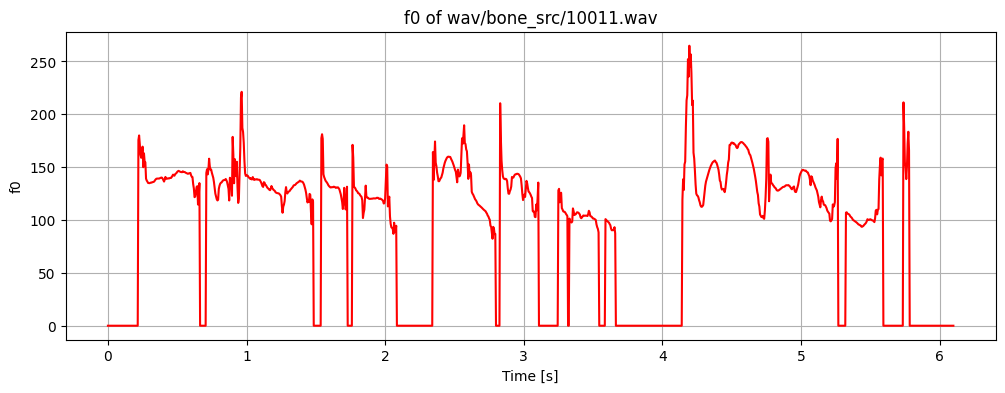

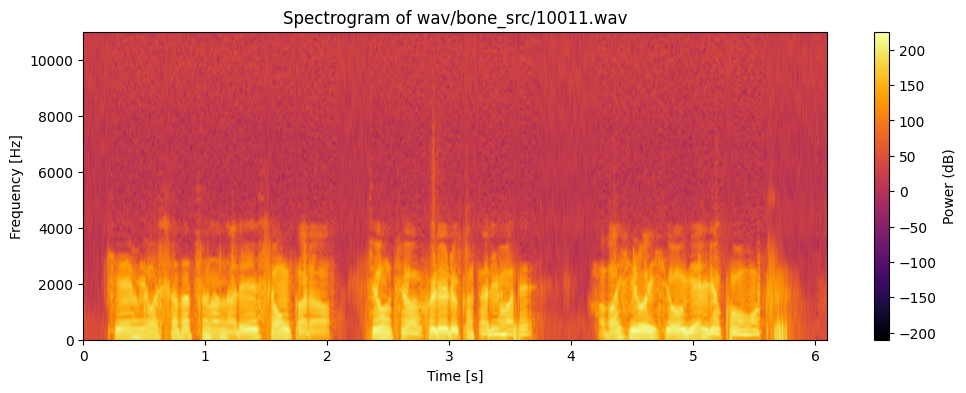

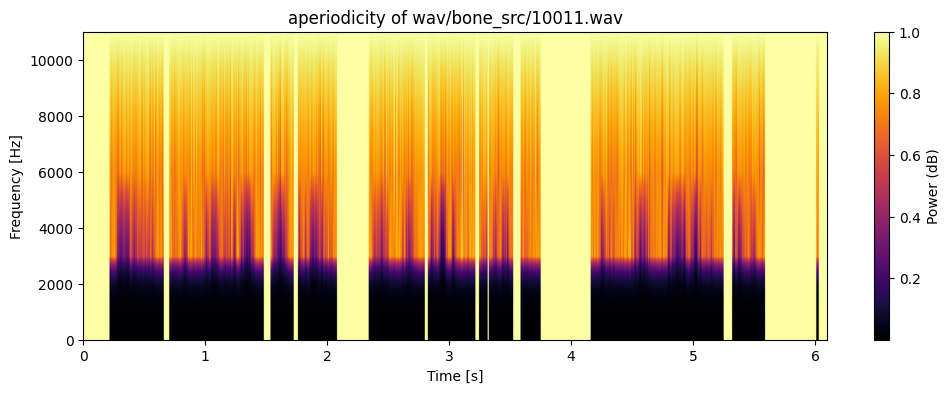

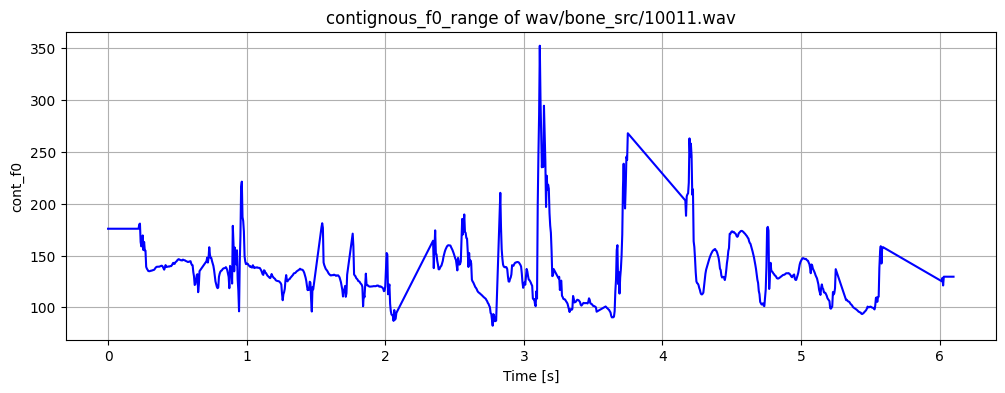

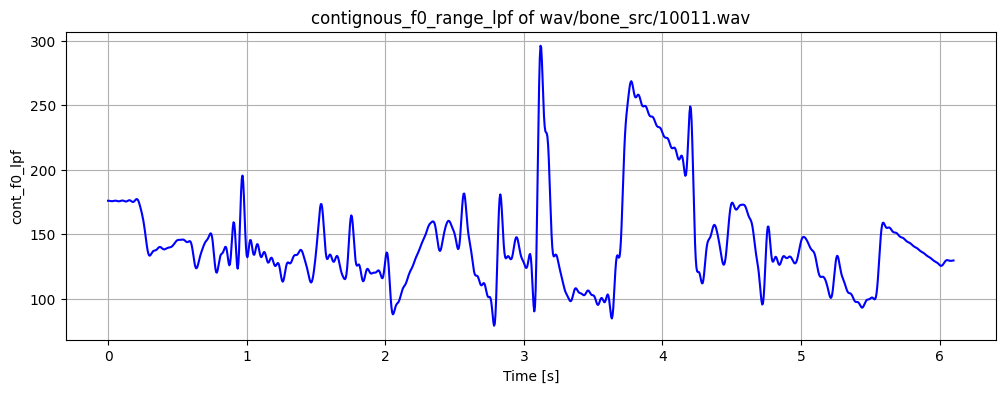

In [7]:
'''
骨伝導音の特徴量抽出、推定特徴量の再合成を行う。
'''
waveforms= 'exp/feature_extract/tr50_bone_src_air_trg/wav_bone_src.scp'
if os.path.isdir(waveforms):
        
    print("args.waveforms はディレクトリです。")
    file_list = sorted(find_files(waveforms, "*.wav"))

else:
    print("args.waveforms はファイルです。")
    file_list = read_txt(waveforms)

    size = len(file_list)
    print(f"file_list のサイズ: {size}")
    #print(f"file_list の内容: {file_list}")

#リストの分割を行う。今回は簡単のために分割しない。
file_lists = np.array_split(file_list, 1)

#numpy配列から、リストへ変換
file_lists = [f_list.tolist() for f_list in file_lists]

n_sample = 0
n_frame = 0
max_frame = 0
count = 1
coeff = np.array([-0.5,0.5,0.0])
print(len(file_lists))
wav_list=[file_lists[0][0]]
print(file_lists[0][0])
for wav_name in wav_list:
    # load wavfile and apply low cut filter
    fs, x = read_wav(wav_name, cutoff=HIGHPASS_CUTOFF)
    n_sample += x.shape[0]
    print(wav_name+" 音声のサンプル数は:"+str(x.shape[0])+" wav_lists内の音声サンプルの総計は:"+str(n_sample)+" "+str(count))
    '''
    ここから、波形表示
    '''
    # 時間軸を作成
    time = np.arange(len(x)) / fs  # サンプル数 ÷ サンプリング周波数 = 時間（秒）
    # 波形をプロット
    plt.figure(figsize=(12, 4))
    plt.plot(time, x, color="blue")
    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title("Waveform of " +file_lists[0][0])
    # グリッドを追加
    plt.grid()
    # 表示
    plt.show()
    '''
    f0、スペクトル包絡、非周期性指標を推定
    
    '''
    time_axis_range, f0_range, spc_range, ap_range = analyze_range(x, fs=fs, minf0=40, maxf0=450, fperiod=SHIFTMS, fftl=FFTL)
    #f0_minが60で固定されたf0
    time_axis, f0, spc, ap = analyze(x, fs=fs, fperiod=SHIFTMS, fftl=FFTL)
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis_range, f0_range, color="blue")
    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("f0_range")
    plt.title("f0_range of " + file_lists[0][0])
    # グリッドを追加
    plt.grid()
    # 表示
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, f0, color="red")
    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("f0")
    plt.title("f0 of "+file_lists[0][0])
    # グリッドを追加
    plt.grid()
    # 表示
    plt.show()
    
    plt.figure(figsize=(12, 4))
    freq_axis_range = np.linspace(0, FS / 2, spc_range.shape[1])
    plt.pcolormesh(time_axis_range,freq_axis_range, 10*np.log(spc_range.T + 1e-10), shading='gouraud', cmap="inferno")

    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Spectrogram of "+ file_lists[0][0])
    # カラーバー（パワー表示）
    plt.colorbar(label="Power (dB)")
    # 表示
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.pcolormesh(time_axis_range,freq_axis_range,ap_range.T, shading='gouraud', cmap="inferno")
    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("aperiodicity of "+ file_lists[0][0])
    # カラーバー（パワー表示）
    plt.colorbar(label="Power (dB)")
    # 表示
    plt.show()
    
    '''
    ここまで、波形表示
    '''
    uv, cont_f0 = convert_continuos_f0(np.array(f0))
    uv_range, cont_f0_range = convert_continuos_f0(np.array(f0_range))
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis_range, cont_f0_range, color="blue")
    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("cont_f0")
    plt.title("contignous_f0_range of "+file_lists[0][0])
    # グリッドを追加
    plt.grid()
    # 表示
    plt.show()
    
    
    #f0にローパスフィルタをかける
    cont_f0_lpf = low_pass_filter(cont_f0, int(1.0 / (SHIFTMS * 0.001)), cutoff=20)
    cont_f0_lpf_range = low_pass_filter(cont_f0_range, int(1.0 / (SHIFTMS * 0.001)), cutoff=20)
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis_range, cont_f0_lpf_range, color="blue")
    # 軸ラベル
    plt.xlabel("Time [s]")
    plt.ylabel("cont_f0_lpf")
    plt.title("contignous_f0_range_lpf of "+file_lists[0][0])
    # グリッドを追加
    plt.grid()
    # 表示
    plt.show()

codeap_range.shape(1221, 2)
mcep_range.shape(1221, 50)
npow_range.shape(1221,)


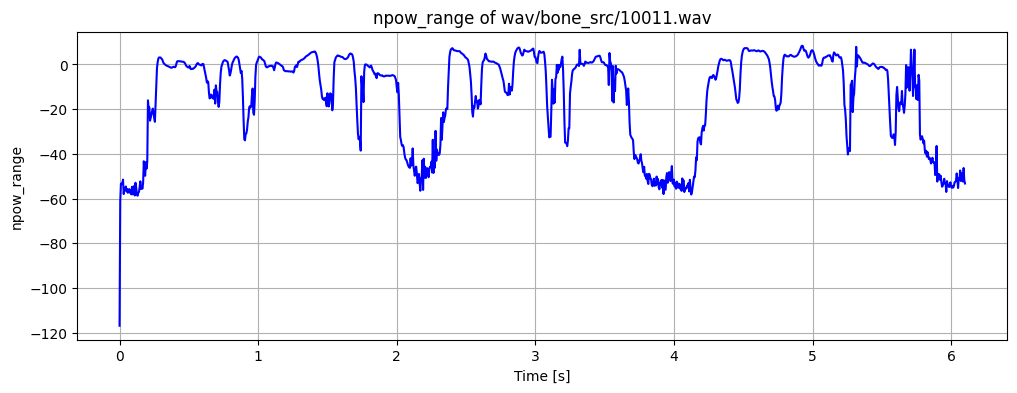

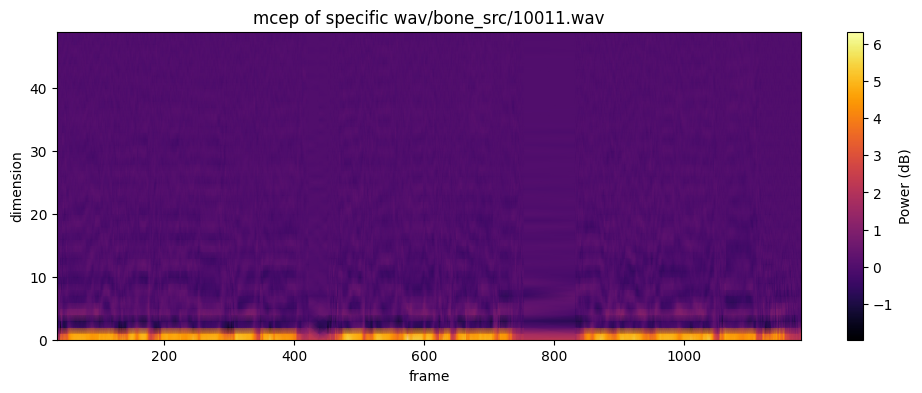

feat_org_lf0.shape(1221, 54)


In [8]:
#帯域非周期性指標の算出
codeap = pw.code_aperiodicity(ap, fs)
codeap_range = pw.code_aperiodicity(ap_range, fs)
print(f"codeap_range.shape{codeap_range.shape}")
mcep = ps.sp2mc(spc, MCEP_DIM, MCEP_ALPHA)
mcep_range = ps.sp2mc(spc_range, MCEP_DIM, MCEP_ALPHA)
print(f"mcep_range.shape{mcep_range.shape}")
#フレームごとのスペクトログラムの平均パワーを算出
npow = spc2npow(spc)
npow_range = spc2npow(spc_range)
print(f"npow_range.shape{npow_range.shape}")
plt.figure(figsize=(12, 4))
plt.plot(time_axis_range, npow_range, color="blue")
# 軸ラベル
plt.xlabel("Time [s]")
plt.ylabel("npow_range")
plt.title("npow_range of "+file_lists[0][0])
# グリッドを追加
plt.grid()
# 表示
plt.show()

#メルケプストラムを、パワー平均が-45以上の区間のみを抽出
mcepspc_range, spcidx_range = extfrm(mcep_range, npow_range, power_threshold=-45)
plt.figure(figsize=(12, 4))
freq_dim_range = np.linspace(0, MCEP_DIM, MCEP_DIM+1)
plt.pcolormesh(spcidx_range,freq_dim_range,mcepspc_range.T, shading='gouraud', cmap="inferno")
# 軸ラベル
plt.xlabel("frame")
plt.ylabel("dimension")
plt.title("mcep of specific "+file_lists[0][0])
# カラーバー（パワー表示）
plt.colorbar(label="Power (dB)")
# 表示
plt.show()
'''
励起特徴量と、メルケプストラムを結合。
この54次元の特徴量が、エンコーダへ入力する特徴量になります。
'''
feat_org_lf0 = np.c_[uv_range,np.log(cont_f0_lpf_range),codeap_range,mcep_range]
print(f"feat_org_lf0.shape{feat_org_lf0.shape}")